# Optimizacion OR-Tools

### Librerias a utilizar

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import heapq
import networkx as nx

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from ortools.linear_solver import pywraplp

### Definicion de los paramaetros

In [34]:
# Coordenadas del perímetro del glaciar
perimeter_points = [
    (2.5,9.2),(2.7,10),(3,11),(3.4,12),(4,13),(4.5,14),(5,15),(5.5,16),(6,17),(7,18),(8,19),(9.5,20),
    (11,20.6),(12,21),(13,21.4),(14,22),(16,22.2),(17,22.4),(18,22.7),(19,22.9),(20,23),(21,23),
    (22,23.1),(23,23.3),(24,23.3),(25,23.3),(26,23.1),(27,22.9),(28,22.8),(29,22.6),(30,22.3),
    (30.9,22),(32,21.7),(33,21),(34,20.5),(35,20.2),(35.5,20),(36,19.9),(37,19.8),(38,19.7),
    (39,19.4),(40,19),(41,18.8),(42,18.4),(43,19),(44,19.3),(45,19.8),(46,20),(47,20.3),(48,20.6),
    (49.5,21),(51,21.3),(52,21.4),(53,21.3),(53.5,21),(54,20.6),(54.5,20),(56,21),(57,20),(57.9,19),
    (57.9,18),(58,17),(57.8,16),(57.3,15),(57,14.5),(56.7,14),(56,13.2),(55,12.3),(54,11.3),(53.5,11),
    (53,10.8),(52,10),(51,9.5),(50,9),(49,8.2),(48.5,8),(48,7.7),(47,7),(46,6.3),(45.5,6),(45,5.5),
    (44.2,5),(43,4.4),(42.3,4),(41,3.4),(40,3),(39,2.8),(38.5,2),(38,1.8),(37,2),(36,2.3),(35,2.8),
    (34,3),(33,3.2),(32,3.4),(31,3.4),(30,3.6),(29,3.8),(28,3.9),(27,3.9),(26,4),(25,4.1),(24,4.2),
    (23,4.2),(22,4.3),(21,4.4),(20,4.5),(19,4.7),(18,4.9),(17,5),(16,5.1),(15,5.3),(14,5.5),(13,5.7),
    (12,6),(11,6.2),(10,6.8),(9,7),(8,7.2),(7,7.7),(6,8),(5,8.4),(4,8.8),(3.5,9),(2.5,9.2)
]

# Crear un Path para el contorno del glaciar
perimeter_path = mpath.Path(np.array(perimeter_points))

# Parámetros del problema
dimension_glaciar = (67, 27)
alcance_nodo = 5
costo_nodo = 100
costo_gateway = 500
presupuesto_maximo = 10000

# Coordenadas del gateway fijo (el más a la derecha)
coordenadas_gateway_fijo = max(perimeter_points, key=lambda x: x[0])


### Variable de decision

In [35]:
# Crear el solver de OR-Tools
solver = pywraplp.Solver.CreateSolver('SCIP')

# Variables de decisión
x = {}  # Nodos
g = {}  # Gateways, excepto el gateway fijo
for i in range(dimension_glaciar[0]):
    for j in range(dimension_glaciar[1]):
        x[i, j] = solver.BoolVar(f'x[{i},{j}]')
        if (i, j) != coordenadas_gateway_fijo:
            g[i, j] = solver.BoolVar(f'g[{i},{j}]')

# Añadir el gateway fijo al modelo
g[coordenadas_gateway_fijo] = solver.BoolVar(f'g[{coordenadas_gateway_fijo[0]},{coordenadas_gateway_fijo[1]}]')
solver.Add(g[coordenadas_gateway_fijo] == 1)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x00000197FC83C300> >

### Variable decision y sus restricciones

In [36]:
# Función objetivo
objective = solver.Objective()
for key, variable in x.items():
    objective.SetCoefficient(variable, costo_nodo)
for key, variable in g.items():
    if key != coordenadas_gateway_fijo:
        objective.SetCoefficient(variable, costo_gateway)
objective.SetMinimization()

# Restricciones
for i in range(dimension_glaciar[0]):
    for j in range(dimension_glaciar[1]):
        if perimeter_path.contains_point((i, j)):
            coverage = solver.Sum(
                [x.get((i2, j2), 0) for i2 in range(max(0, i - alcance_nodo), min(dimension_glaciar[0], i + alcance_nodo + 1))
                 for j2 in range(max(0, j - alcance_nodo), min(dimension_glaciar[1], j + alcance_nodo + 1))
                 if perimeter_path.contains_point((i2, j2))]
            ) + g.get((i, j), 0)
            solver.Add(coverage >= 1)

# Presupuesto total no debe ser excedido
solver.Add(
    solver.Sum([x[i, j] * costo_nodo + g[i, j] * costo_gateway for i in range(dimension_glaciar[0])
                for j in range(dimension_glaciar[1])]) <= presupuesto_maximo
)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x00000197F85E2730> >

### Resolución del modelo

In [37]:
# Resolver el modelo
status = solver.Solve()

#Imagen de fondo
img = mpimg.imread('glaciar.jpg')

### Visualización de los resultados

Solución óptima encontrada:
Total de nodos activos: 10
Total de gateways activos : 1

Coordenadas de los nodos activos:
(8, 11)
(12, 17)
(15, 10)
(23, 18)
(26, 9)
(34, 17)
(35, 7)
(41, 14)
(46, 9)
(52, 16)

Coordenadas de los gateways activos:

Coordenadas del gateway fijo:
(58, 17)


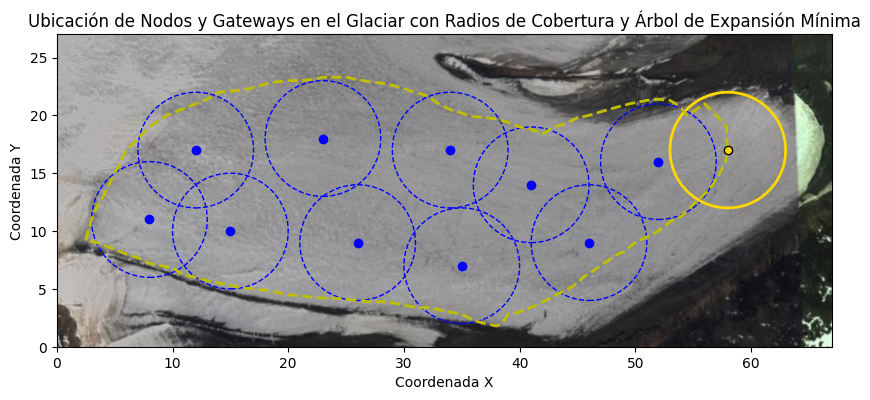

In [38]:
if status == pywraplp.Solver.OPTIMAL:
    print("Solución óptima encontrada:")
    nodos_activos = [(i, j) for i in range(dimension_glaciar[0]) for j in range(dimension_glaciar[1]) if x[i, j].solution_value() > 0]
    gateways_activos = [(i, j) for i in range(dimension_glaciar[0]) for j in range(dimension_glaciar[1]) if g[i, j].solution_value() > 0 and (i, j) != coordenadas_gateway_fijo]

    total_nodos = len(nodos_activos)
    total_gateways = len(gateways_activos) + 1
    print(f"Total de nodos activos: {total_nodos}")
    print(f"Total de gateways activos : {total_gateways}")

    # Coordenadas de los nodos activos
    print("\nCoordenadas de los nodos activos:")
    for nodo in nodos_activos:
        print(nodo)

    # Coordenadas de los gateways activos
    print("\nCoordenadas de los gateways activos:")
    for gateway in gateways_activos:
        print(gateway)

    # Coordenadas del gateway fijo
    print("\nCoordenadas del gateway fijo:")
    print(coordenadas_gateway_fijo)

    # Construir la lista de nodos para el algoritmo de Prim
    todos_los_nodos = nodos_activos + gateways_activos + [coordenadas_gateway_fijo]

    # Visualizar los resultados
    plt.figure(figsize=(10, 8))

    x_coords, y_coords = zip(*perimeter_points)
    plt.plot(x_coords, y_coords, 'y--', linewidth=2)
    plt.imshow(img, extent=[0, dimension_glaciar[0], 0, dimension_glaciar[1]], zorder=0)

    for nodo in nodos_activos:
        plt.scatter(*nodo, color='blue')
        circle = plt.Circle(nodo, alcance_nodo, color='blue', fill=False, linestyle='--')
        plt.gca().add_patch(circle)

    for gateway in gateways_activos:
        plt.scatter(*gateway, color='red')
        circle = plt.Circle(gateway, alcance_nodo, color='red', fill=False)
        plt.gca().add_patch(circle)

    plt.scatter(*coordenadas_gateway_fijo, color='gold', edgecolors='black', zorder=5)
    circle_raiz = plt.Circle(coordenadas_gateway_fijo, alcance_nodo, color='gold', fill=False, linestyle='-', linewidth=2)
    plt.gca().add_patch(circle_raiz)

    plt.title('Ubicación de Nodos y Gateways en el Glaciar con Radios de Cobertura y Árbol de Expansión Mínima')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.show()
else:
    print("No se encontró una solución óptima.")

# Rutas más optimas

### Parametros a tomar en cuenta y  Calcular la distancia entre nodos

In [39]:
# Las coordenadas del perímetro no se vuelven a colocar por que se definio arriba antes

# Coordenadas de los nodos
nodos = [
    (8, 11),
    (12, 17),
    (15, 10),
    (23, 18),
    (26, 9),
    (34, 17),
    (35, 7),
    (41, 14),
    (46, 9),
    (52, 16),
    (58, 17)  # Este es el Gateway
]

# Número de nodos, incluyendo el gateway fijo
num_nodos = len(nodos)

# Crear un grafo vacío
G = nx.Graph()

# Agregar nodos al grafo y calcular las distancias
distancias = {}
for i, nodo in enumerate(nodos):
    G.add_node(i, pos=nodo)
    for j in range(i + 1, num_nodos):
        distancia = ((nodos[i][0] - nodos[j][0]) ** 2 + (nodos[i][1] - nodos[j][1]) ** 2) ** 0.5
        G.add_edge(i, j, weight=distancia)
        distancias[(i, j)] = distancia

# Imprimir todas las distancias entre los nodos
print("Distancias entre los nodos:")
for par, distancia in distancias.items():
    print(f"Nodo {par[0]} a Nodo {par[1]}: {distancia:.2f}")
    

# Calcular el MST usando el algoritmo de Prim
mst = nx.minimum_spanning_tree(G, weight='weight')


Distancias entre los nodos:
Nodo 0 a Nodo 1: 7.21
Nodo 0 a Nodo 2: 7.07
Nodo 0 a Nodo 3: 16.55
Nodo 0 a Nodo 4: 18.11
Nodo 0 a Nodo 5: 26.68
Nodo 0 a Nodo 6: 27.29
Nodo 0 a Nodo 7: 33.14
Nodo 0 a Nodo 8: 38.05
Nodo 0 a Nodo 9: 44.28
Nodo 0 a Nodo 10: 50.36
Nodo 1 a Nodo 2: 7.62
Nodo 1 a Nodo 3: 11.05
Nodo 1 a Nodo 4: 16.12
Nodo 1 a Nodo 5: 22.00
Nodo 1 a Nodo 6: 25.08
Nodo 1 a Nodo 7: 29.15
Nodo 1 a Nodo 8: 34.93
Nodo 1 a Nodo 9: 40.01
Nodo 1 a Nodo 10: 46.00
Nodo 2 a Nodo 3: 11.31
Nodo 2 a Nodo 4: 11.05
Nodo 2 a Nodo 5: 20.25
Nodo 2 a Nodo 6: 20.22
Nodo 2 a Nodo 7: 26.31
Nodo 2 a Nodo 8: 31.02
Nodo 2 a Nodo 9: 37.48
Nodo 2 a Nodo 10: 43.57
Nodo 3 a Nodo 4: 9.49
Nodo 3 a Nodo 5: 11.05
Nodo 3 a Nodo 6: 16.28
Nodo 3 a Nodo 7: 18.44
Nodo 3 a Nodo 8: 24.70
Nodo 3 a Nodo 9: 29.07
Nodo 3 a Nodo 10: 35.01
Nodo 4 a Nodo 5: 11.31
Nodo 4 a Nodo 6: 9.22
Nodo 4 a Nodo 7: 15.81
Nodo 4 a Nodo 8: 20.00
Nodo 4 a Nodo 9: 26.93
Nodo 4 a Nodo 10: 32.98
Nodo 5 a Nodo 6: 10.05
Nodo 5 a Nodo 7: 7.62
Nodo 5 

### visualización de los resultados

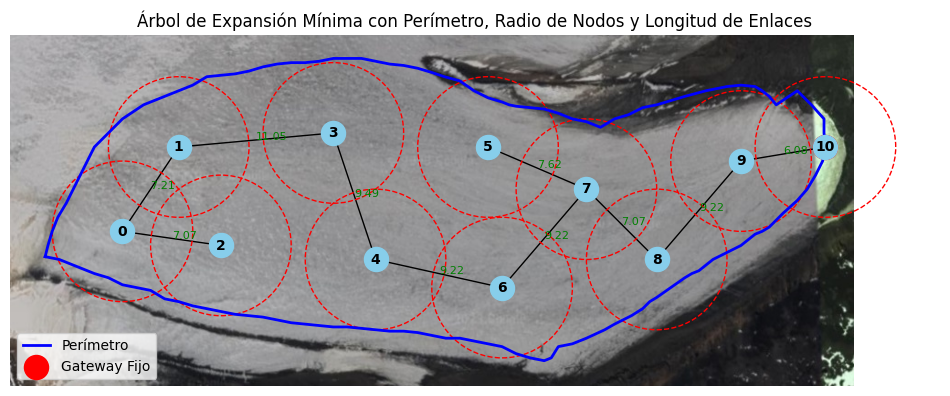

In [40]:
# Preparar la visualización del grafo
fig, ax = plt.subplots(figsize=(12, 8))

# Cargar la imagen de fondo
bg_image = plt.imread('glaciar.jpg')  # Reemplaza 'ruta/a/tu/imagen.jpg' con la ruta de tu imagen
ax.imshow(bg_image, extent=[0, 60, 0, 25])  # Ajusta los valores de extent según tus necesidades

# Dibujar el perímetro
x_perimeter, y_perimeter = zip(*perimeter_points)
ax.plot(x_perimeter, y_perimeter, 'b-', linewidth=2, label='Perímetro')

# Extract node positions from the graph attributes
node_positions = {node: data['pos'] for node, data in G.nodes(data=True)}

# Draw the MST using the extracted positions
nx.draw(mst, node_positions, ax=ax, with_labels=True, node_size=300, node_color='skyblue', font_size=10,
        font_color='black', font_weight='bold')

# Etiquetar el largo de cada enlace en el MST
for (nodo_a, nodo_b, data) in mst.edges(data=True):
    x = [nodos[nodo_a][0], nodos[nodo_b][0]]
    y = [nodos[nodo_a][1], nodos[nodo_b][1]]
    distancia = data['weight']
    ax.text(sum(x) / 2, sum(y) / 2, f"{distancia:.2f}", color='green', fontsize=8)

# Dibujar un círculo alrededor de cada nodo con radio de 5 unidades
for nodo in nodos:
    circulo = mpatches.Circle(nodo, 5, fill=False, color='red', linestyle='dashed')
    ax.add_patch(circulo)

# Resaltar el nodo del gateway fijo
nodo_gateway = num_nodos - 1
ax.scatter(nodos[nodo_gateway][0], nodos[nodo_gateway][1], color='red', s=300, label='Gateway Fijo')

ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')
ax.set_title('Árbol de Expansión Mínima con Perímetro, Radio de Nodos y Longitud de Enlaces')
ax.legend()
ax.grid(True)
plt.show()


# Matriz de trafico

### Definición de parametros

In [41]:
# Tiempo de transmisión en minutos y tasas de transferencia en Mbps
trans_time = 30  # minutos
download_rate = 150  # Mbps
upload_rate = 50  # Mbps

# Transformar Mbps a MB por hora
download_rate_MB = (download_rate * trans_time) / 8
upload_rate_MB = (upload_rate * trans_time) / 8

# Nodos en la red
nodes = list(range(11))

# Conexiones entre nodos: cada nodo tiene una lista de nodos a los que está conectado
connections = {
    0: [1, 2],
    1: [3],
    2: [],
    3: [4],
    4: [6],
    5: [7],
    6: [7],
    7: [8],
    8: [9],
    9: [10],
    10: []  
}

### visualización de los resultados

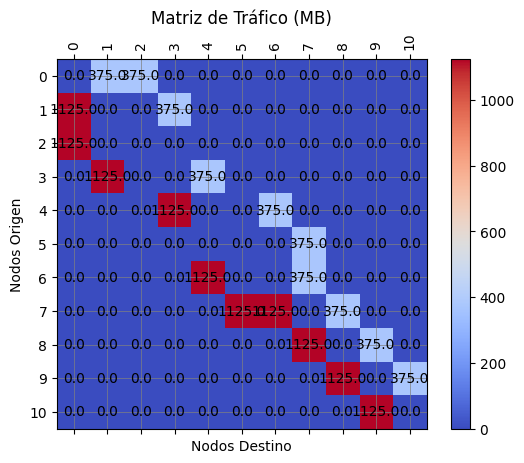

In [42]:
# Inicializar la matriz de tráfico con ceros
traffic_matrix = np.zeros((len(nodes), len(nodes)))

# Rellenar la matriz de tráfico con las tasas de subida y bajada
for node, parents in connections.items():
    for parent in parents:
        traffic_matrix[node][parent] += upload_rate_MB
        traffic_matrix[parent][node] += download_rate_MB

# Multiplicar por 2 para considerar ida y vuelta
traffic_matrix *= 2

# Crear una figura y un eje para la visualización
fig, ax = plt.subplots()

# Usar 'imshow' para visualizar la matriz de tráfico
cax = ax.matshow(traffic_matrix, cmap='coolwarm')

# Agregar una barra de color para la escala
fig.colorbar(cax)

# Configurar las grillas y etiquetas
ax.set_xticks(np.arange(len(nodes)))
ax.set_yticks(np.arange(len(nodes)))
ax.set_xticklabels(nodes)
ax.set_yticklabels(nodes)

# Rotar las etiquetas del eje x y configurar su alineación
plt.xticks(rotation=90, ha='center')

# Agregar etiquetas de eje y título
ax.set_xlabel('Nodos Destino')
ax.set_ylabel('Nodos Origen')
ax.set_title('Matriz de Tráfico (MB)')

# Activar la grilla
ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5)

# Mostrar las etiquetas dentro de los cuadros
for i in range(len(nodes)):
    for j in range(len(nodes)):
        c = traffic_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

# Mostrar la matriz
plt.show()

